In [31]:
#!/usr/bin/env python3
"""
Node2Vec norm–degree dependence tests (two extremes, with rigorous nonparametrics)

You said you'll use your Node2Vec implementation from `node2vecs.torch.TorchNode2Vec`.
This script:
  • Builds two graphs with same n and average degree: (1) k-regular; (2) heterogeneous (power-law Chung–Lu)
  • Trains Node2Vec (your TorchNode2Vec) with identical hyperparams on both
  • Extracts node norms r_i and degrees k_i
  • Runs shape-agnostic dependence tests with permutation p-values:
      - Distance correlation (dCor)
      - HSIC (Gaussian kernel, median heuristic)
      - Mutual information (kNN/KSG-style via sklearn's mutual_info_regression)
      - Predictability: Kernel Ridge (RBF) cross-validated R^2
  • Does degree-only mechanism checks:
      - Degree-preserving rewiring (double-edge swaps), re-embed, re-test
      - Unit-norm ablation on embeddings (renormalize rows to 1), re-test

Requires: numpy, scipy, networkx, scikit-learn, scipy, pandas (for pretty tables), and your `node2vecs` package.
Install (example):
  pip install numpy scipy networkx scikit-learn pandas

Run:
  python node2vec_degree_norm_tests.py --n 2000 --k 12 --gamma 2.5 --walks 10 --walklen 80 --dim 128 --epochs 5

Outputs: concise text tables of effect sizes and permutation p-values for the two graphs,
plus the ablations (rewired, unit-norm).
"""
from __future__ import annotations

# --- stdlib ---
import argparse
import math
import random
from dataclasses import dataclass
from typing import Tuple, Dict

# --- deps ---
import numpy as np
import pandas as pd
import scipy.sparse as sp
import networkx as nx
from sklearn.model_selection import KFold
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics.pairwise import pairwise_kernels

# your Node2Vec
from node2vecs.torch.torch_node2vec import TorchNode2Vec

# ==========================
# Reproducibility
# ==========================

def set_all_seeds(seed: int = 42):
    np.random.seed(seed)
    random.seed(seed)

# ==========================
# Graph generation
# ==========================

def build_k_regular(n: int, k: int, seed: int = 42) -> networkx.Graph:
    if k >= n:
        raise ValueError("k must be < n")
    if (n * k) % 2 != 0:
        n += 1  # make it graphic
    return nx.random_regular_graph(k, n, seed=seed)


def build_powerlaw_chung_lu(n: int, avg_k: float, gamma: float = 2.5, seed: int = 42) -> networkx.Graph:
    """Heavy-tailed degrees via Chung–Lu with power-law expected degrees.
    We sample continuous Pareto-like targets and scale to hit avg_k.
    """
    rng = np.random.default_rng(seed)
    u = rng.random(n)
    x_min = 1.0
    # inverse CDF for power-law with exponent gamma (>1): x = x_min (1-u)^(-1/(gamma-1))
    raw = x_min * (1 - u) ** (-1.0 / (gamma - 1.0))
    raw = raw / raw.mean() * avg_k
    w = np.maximum(raw, 1e-3)
    G = nx.expected_degree_graph(w, selfloops=False, seed=seed)
    G = nx.Graph(G)
    G.remove_edges_from(nx.selfloop_edges(G))
    if not nx.is_connected(G):
        G = G.subgraph(max(nx.connected_components(G), key=len)).copy()
    return G

# ==========================
# Node2Vec wrapper (your impl)
# ==========================

@dataclass
class N2VConfig:
    dim: int = 128
    epochs: int = 1
    window: int = 10
    num_walks: int = 10
    walk_length: int = 80
    manifold: bool = False
    negative: int = 5
    lr: float = 1e-3
    p: float = 1.0
    q: float = 1.0
    device: str = "cuda:0"
    seed: int = 42
    temperature: float | None = None  # passed through if supported


def embed_with_torch_node2vec(G: networkx.Graph, cfg: N2VConfig) -> np.ndarray:
    """Use your TorchNode2Vec to fit and return IN-embeddings (U).
    TorchNode2Vec.fit expects a (sparse) adjacency; we build CSR.
    """
    set_all_seeds(cfg.seed)
    n = G.number_of_nodes()
    # ensure nodes are 0..n-1
    mapping = {v: i for i, v in enumerate(G.nodes())}
    G = nx.relabel_nodes(G, mapping)
    rows, cols = zip(*G.edges()) if G.number_of_edges() > 0 else ([], [])
    data = np.ones(len(rows), dtype=np.float32)
    A = sp.csr_matrix((data, (rows, cols)), shape=(n, n))
    A = A + A.T

    n2v = TorchNode2Vec(
        device=cfg.device,
        batch_size=256,
        buffer_size=100000,
        context_window_type="double",
        miniters=200,
        num_workers=4,
        alpha=cfg.lr,
        learn_outvec=True,
        similarity_metric="dot",
        manifold=cfg.manifold,
        window=cfg.window,
        num_walks=cfg.num_walks,
        epochs=cfg.epochs,
        negative=cfg.negative,
        p=cfg.p,
        q=cfg.q,
        walk_length=cfg.walk_length,
        temperature=cfg.temperature,
    )
    n2v.fit(A)
    n2v.update_embedding(cfg.dim)
    U = np.asarray(n2v.in_vec, dtype=np.float64)
    V = np.asarray(n2v.out_vec, dtype=np.float64)

    return U, V

# ==========================
# Statistics: dependence tests
# ==========================

def _centered_distance_matrix(x: np.ndarray) -> np.ndarray:
    # pairwise absolute distances for 1D; Euclidean for >1D
    a = np.abs(x[:, None] - x[None, :]) if x.ndim == 1 else np.linalg.norm(x[:, None, :] - x[None, :, :], axis=2)
    n = a.shape[0]
    A = a - a.mean(axis=0, keepdims=True) - a.mean(axis=1, keepdims=True) + a.mean()
    return A


def distance_correlation(x: np.ndarray, y: np.ndarray) -> float:
    Ax = _centered_distance_matrix(x)
    Ay = _centered_distance_matrix(y)
    n = Ax.shape[0]
    dcov2 = (Ax * Ay).sum() / (n * n)
    dvarx = (Ax * Ax).sum() / (n * n)
    dvary = (Ay * Ay).sum() / (n * n)
    if dvarx <= 0 or dvary <= 0:
        return 0.0
    return float(math.sqrt(max(dcov2, 0.0) / math.sqrt(dvarx * dvary)))


def hsic_rbf(x: np.ndarray, y: np.ndarray) -> float:
    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)
    # median heuristic bandwidths
    def med_heur(z):
        Dz = _centered_distance_matrix(z.squeeze())
        med = np.median(np.abs(Dz))
        return med if med > 1e-12 else 1.0
    sx = med_heur(x)
    sy = med_heur(y)
    Kx = pairwise_kernels(x, metric="rbf", gamma=1.0 / (2 * sx * sx))
    Ky = pairwise_kernels(y, metric="rbf", gamma=1.0 / (2 * sy * sy))
    n = Kx.shape[0]
    H = np.eye(n) - np.ones((n, n)) / n
    Kc = H @ Kx @ H
    Lc = H @ Ky @ H
    hsic = np.trace(Kc @ Lc) / ((n - 1) ** 2)
    return float(hsic)


def mutual_info_knn(x: np.ndarray, y: np.ndarray, seed: int = 42) -> float:
    # sklearn's MI regressor with kNN backend
    rng = np.random.RandomState(seed)
    mi = mutual_info_regression(x.reshape(-1, 1), y, random_state=rng, discrete_features=False)
    return float(mi[0])


def kernel_ridge_cv_r2(k: np.ndarray, r: np.ndarray, n_splits: int = 5) -> float:
    # Predict r from k with RBF Kernel Ridge; report out-of-fold R^2 (no shape assumption)
    X = k.reshape(-1, 1)
    y = r
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []
    for tr, te in kf.split(X):
        kr = KernelRidge(kernel="rbf", alpha=1e-3, gamma=None)
        kr.fit(X[tr], y[tr])
        yp = kr.predict(X[te])
        scores.append(r2_score(y[te], yp))
    return float(np.mean(scores))


def permutation_test(stat_fn, k: np.ndarray, r: np.ndarray, B: int = 1000, seed: int = 42) -> Tuple[float, float]:
    rng = np.random.default_rng(seed)
    stat_obs = stat_fn(k, r)
    cnt = 0
    for _ in range(B):
        perm = rng.permutation(len(k))
        s = stat_fn(k[perm], r)
        cnt += (s >= stat_obs)
    p = (cnt + 1) / (B + 1)
    return float(stat_obs), float(p)

# ==========================
# Mechanism checks
# ==========================

def unit_norm(X: np.ndarray) -> np.ndarray:
    r = np.linalg.norm(X, axis=1, keepdims=True)
    return X / np.clip(r, 1e-12, None)


def degree_preserving_rewire(G: networkx.Graph, n_swaps: int, seed: int = 42) -> networkx.Graph:
    H = G.copy()
    nx.double_edge_swap(H, nswap=n_swaps, max_tries=n_swaps * 10, seed=seed)
    H.remove_edges_from(nx.selfloop_edges(H))
    return H

# ==========================
# Pipeline for one graph
# ==========================

def run_all_for_graph(G: networkx.Graph, cfg: N2VConfig, *, do_rewire: bool = True) -> Dict[str, float]:
    # 1) Embed
    U, V = embed_with_torch_node2vec(G, cfg)
    r = np.linalg.norm(U, axis=1)
    deg = np.array([d for _, d in G.degree()], dtype=float)

    # 2) Tests
    out: Dict[str, float] = {}
    dc, p_dc = permutation_test(lambda a,b: distance_correlation(a,b), deg, r)
    hs, p_hs = permutation_test(lambda a,b: hsic_rbf(a,b), deg, r)
    mi, p_mi = permutation_test(lambda a,b: mutual_info_knn(a,b), deg, r)
    r2 = kernel_ridge_cv_r2(deg, r)

    out.update(dict(dCor=dc, p_dCor=p_dc, HSIC=hs, p_HSIC=p_hs, MI=mi, p_MI=p_mi, KR_R2=r2))

    # 3) Unit-norm ablation
    Uu = unit_norm(U)
    ru = np.linalg.norm(Uu, axis=1)  # should be ~1
    dc_u, p_dc_u = permutation_test(lambda a,b: distance_correlation(a,b), deg, ru)
    hs_u, p_hs_u = permutation_test(lambda a,b: hsic_rbf(a,b), deg, ru)
    mi_u, p_mi_u = permutation_test(lambda a,b: mutual_info_knn(a,b), deg, ru)
    r2_u = kernel_ridge_cv_r2(deg, ru)
    out.update(dict(dCor_unit=dc_u, p_dCor_unit=p_dc_u, HSIC_unit=hs_u, p_HSIC_unit=p_hs_u, MI_unit=mi_u, p_MI_unit=p_mi_u, KR_R2_unit=r2_u))

    # 4) Degree-preserving rewiring
    if do_rewire:
        n_swaps = max(10 * G.number_of_edges(), 1)
        Grew = degree_preserving_rewire(G, n_swaps=n_swaps, seed=cfg.seed + 17)
        Urew, Vrew = embed_with_torch_node2vec(Grew, cfg)
        rrew = np.linalg.norm(Urew, axis=1)
        degrew = np.array([d for _, d in Grew.degree()], float)
        dc_w, p_dc_w = permutation_test(lambda a,b: distance_correlation(a,b), degrew, rrew)
        hs_w, p_hs_w = permutation_test(lambda a,b: hsic_rbf(a,b), degrew, rrew)
        mi_w, p_mi_w = permutation_test(lambda a,b: mutual_info_knn(a,b), degrew, rrew)
        r2_w = kernel_ridge_cv_r2(degrew, rrew)
        out.update(dict(dCor_rewire=dc_w, p_dCor_rewire=p_dc_w, HSIC_rewire=hs_w, p_HSIC_rewire=p_hs_w, MI_rewire=mi_w, p_MI_rewire=p_mi_w, KR_R2_rewire=r2_w))

    return out

# ==========================
# Main
# ==========================
 

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# from node2vec_degree_norm_tests import (
#     build_k_regular,
#     build_powerlaw_chung_lu,
#     N2VConfig,
#     embed_with_torch_node2vec,
# )

n = 10000
k = 10
gamma = 2.5
seed = 42

G_reg = build_k_regular(n, k, seed=seed)
avg_k = 2 * G_reg.number_of_edges() / G_reg.number_of_nodes()
G_het = build_powerlaw_chung_lu(n, avg_k, gamma=gamma, seed=seed)

cfg = N2VConfig(dim=128, epochs=1, device="cuda:0", seed=seed)

U_reg, V_reg = embed_with_torch_node2vec(G_reg, cfg)
U_het, V_het = embed_with_torch_node2vec(G_het, cfg)


deg_reg = np.array([d for _, d in G_reg.degree()])
norm_reg = np.linalg.norm(U_reg, axis=1)

deg_het = np.array([d for _, d in G_het.degree()])
norm_het = np.linalg.norm(U_het, axis=1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30929/30929 [06:37<00:00, 77.73it/s, loss=2.42]


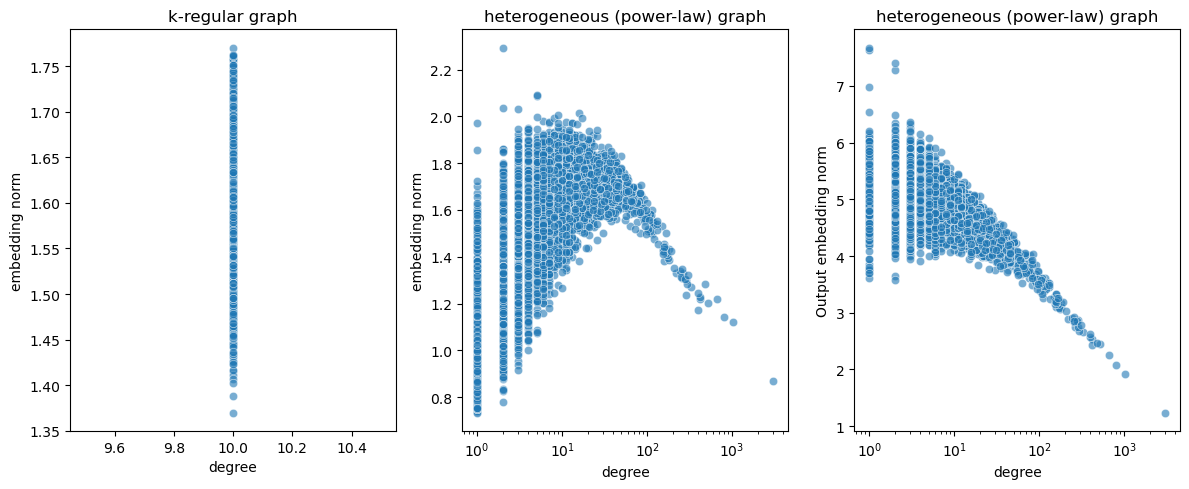

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

sns.scatterplot(x=deg_reg, y=norm_reg, alpha=0.6, ax=axes[0])
axes[0].set_title("k-regular graph")
axes[0].set_xlabel("degree")
axes[0].set_ylabel("embedding norm")

sns.scatterplot(x=deg_het, y=norm_het, alpha=0.6, ax=axes[1])
axes[1].set_title("heterogeneous (power-law) graph")
axes[1].set_xlabel("degree")
axes[1].set_xscale("log")
axes[1].set_ylabel("embedding norm")

sns.scatterplot(x=deg_het, y= np.linalg.norm(V_het, axis=1), alpha=0.6, ax=axes[2])
axes[2].set_title("heterogeneous (power-law) graph")
axes[2].set_xlabel("degree")
axes[2].set_xscale("log")
axes[2].set_ylabel("Output embedding norm")

plt.tight_layout()
plt.show()

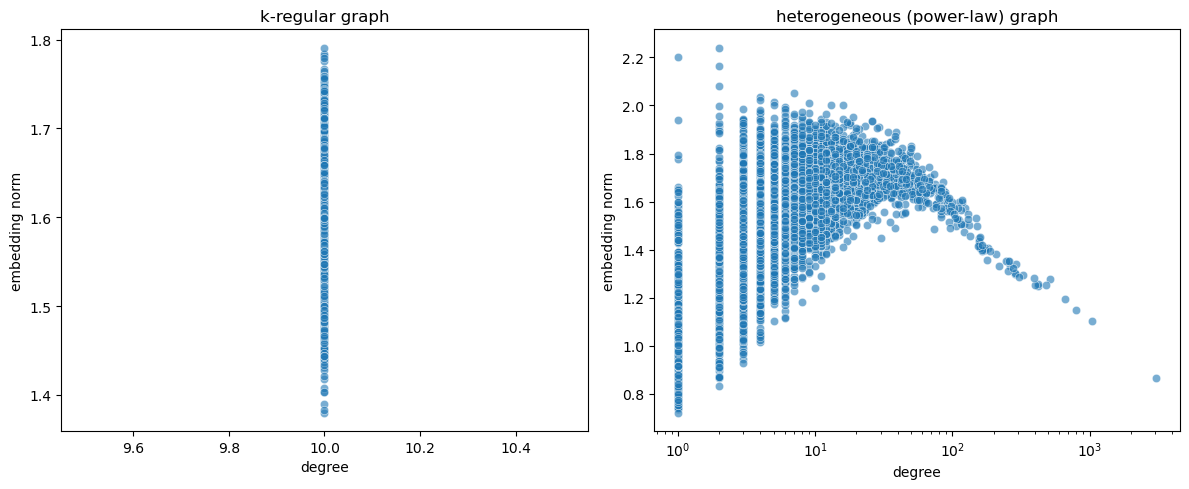

In [35]:
cfg = N2VConfig(dim=128, epochs=1, device="cuda:0", manifold=True, seed=seed)

U_reg_s, V_reg_s = embed_with_torch_node2vec(G_reg, cfg)
U_het_s , V_het_s= embed_with_torch_node2vec(G_het, cfg)

norm_reg_s = np.linalg.norm(U_reg_s, axis=1)
norm_het_s = np.linalg.norm(U_het_s, axis=1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30929/30929 [06:00<00:00, 85.68it/s, loss=2.88]


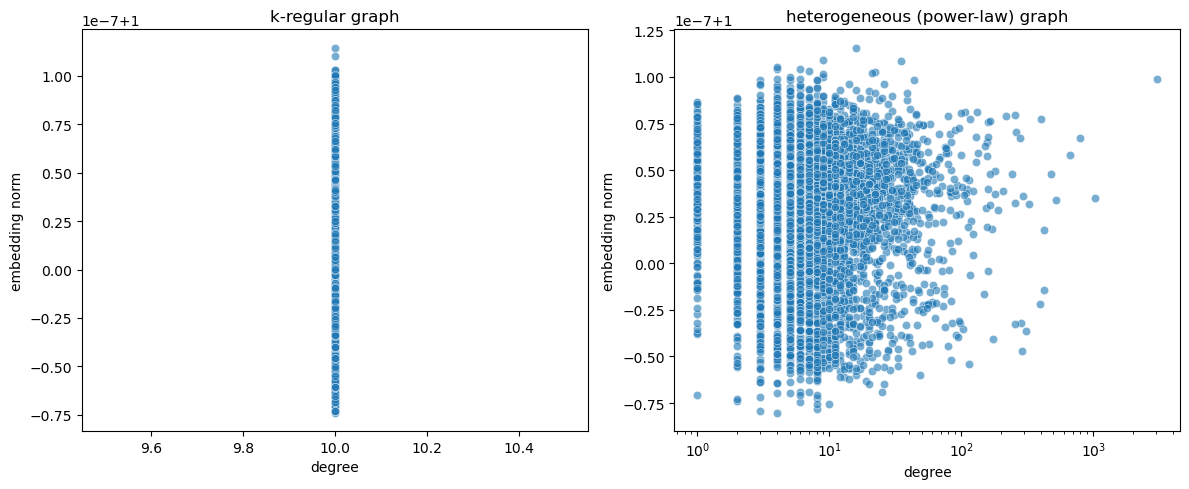

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

sns.scatterplot(x=deg_reg, y=norm_reg_s, alpha=0.6, ax=axes[0])
axes[0].set_title("k-regular graph")
axes[0].set_xlabel("degree")
axes[0].set_ylabel("embedding norm")

sns.scatterplot(x=deg_het, y=norm_het_s, alpha=0.6, ax=axes[1])
axes[1].set_title("heterogeneous (power-law) graph")
axes[1].set_xlabel("degree")
axes[1].set_xscale("log")
axes[1].set_ylabel("embedding norm")

sns.scatterplot(x=deg_het, y= np.linalg.norm(V_het_s, axis=1), alpha=0.6, ax=axes[2])
axes[2].set_title("heterogeneous (power-law) graph")
axes[2].set_xlabel("degree")
axes[2].set_xscale("log")
axes[2].set_ylabel("Output embedding norm")

plt.tight_layout()
plt.show()

In [20]:
np.unique(deg_het)

array([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
         12,   13,   14,   15,   16,   17,   18,   19,   20,   21,   22,
         23,   24,   25,   26,   27,   28,   29,   30,   31,   32,   33,
         34,   35,   36,   37,   38,   39,   40,   41,   42,   43,   44,
         45,   46,   47,   48,   49,   50,   51,   52,   53,   54,   55,
         56,   57,   58,   59,   60,   61,   62,   63,   64,   66,   68,
         69,   70,   71,   72,   73,   74,   75,   76,   79,   80,   81,
         82,   83,   84,   85,   88,   89,   90,   91,   92,   93,   94,
         95,   96,   97,   98,  100,  102,  103,  105,  106,  108,  109,
        110,  111,  112,  115,  117,  118,  122,  123,  130,  132,  135,
        148,  152,  153,  156,  157,  159,  160,  165,  172,  174,  180,
        181,  189,  208,  219,  244,  254,  255,  257,  262,  278,  284,
        287,  292,  307,  328,  396,  401,  420,  479,  518,  666,  801,
       1038, 3045])

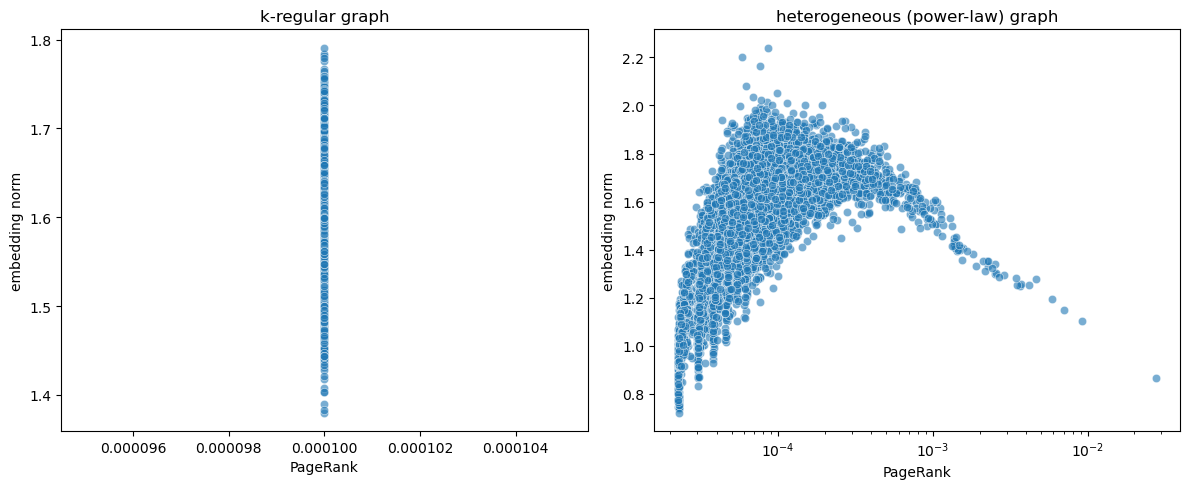

In [27]:
import networkx as nx

# compute pagerank
pr_reg = nx.pagerank(G_reg)
pr_het = nx.pagerank(G_het)

# convert to arrays aligned with embeddings
pr_reg_arr = np.array([pr_reg[node] for node in G_reg.nodes()])
pr_het_arr = np.array([pr_het[node] for node in G_het.nodes()])

# scatter plots: norm vs pagerank
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.scatterplot(x=pr_reg_arr, y=norm_reg, alpha=0.6, ax=axes[0])
axes[0].set_title("k-regular graph")
axes[0].set_xlabel("PageRank")
axes[0].set_ylabel("embedding norm")

sns.scatterplot(x=pr_het_arr, y=norm_het, alpha=0.6, ax=axes[1])
axes[1].set_title("heterogeneous (power-law) graph")
axes[1].set_xlabel("PageRank")
axes[1].set_xscale("log")
#axes[1].set_yscale("log")
axes[1].set_ylabel("embedding norm")

sns.scatterplot(x=pr_het_arr, y=np.linalg.norm(V_het, axis=1), alpha=0.6, ax=axes[2])
axes[2].set_title("heterogeneous (power-law) graph")
axes[2].set_xlabel("PageRank")
axes[2].set_xscale("log")
#axes[2].set_yscale("log")
axes[2].set_ylabel("Output embedding norm")

plt.tight_layout()
plt.show()


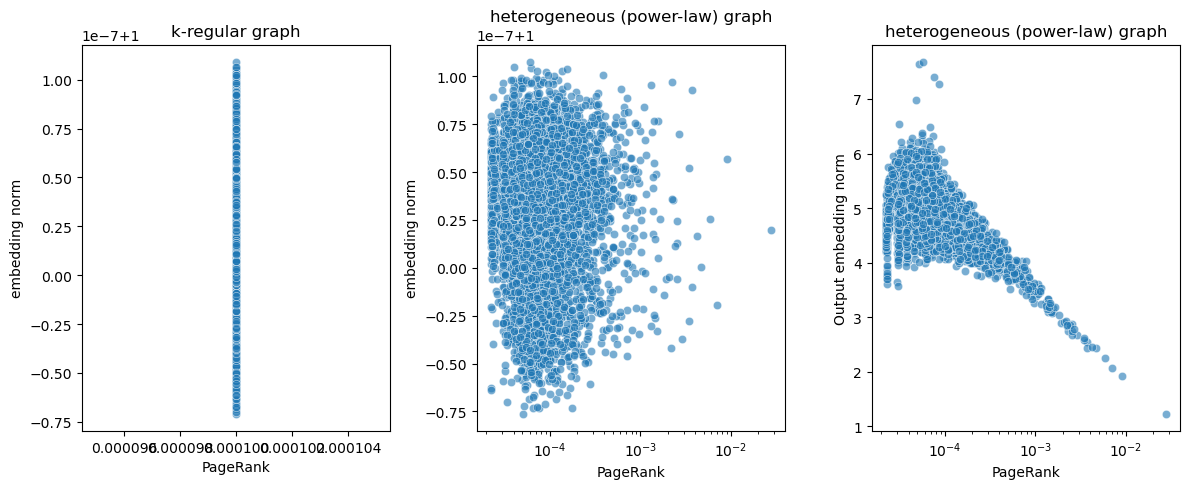

In [37]:

# scatter plots: norm vs pagerank
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

sns.scatterplot(x=pr_reg_arr, y=norm_reg_s, alpha=0.6, ax=axes[0])
axes[0].set_title("k-regular graph")
axes[0].set_xlabel("PageRank")
axes[0].set_ylabel("embedding norm")

sns.scatterplot(x=pr_het_arr, y=norm_het_s, alpha=0.6, ax=axes[1])
axes[1].set_title("heterogeneous (power-law) graph")
axes[1].set_xlabel("PageRank")
axes[1].set_xscale("log")
#axes[1].set_yscale("log")
axes[1].set_ylabel("embedding norm")

sns.scatterplot(x=pr_het_arr, y=np.linalg.norm(V_het, axis=1), alpha=0.6, ax=axes[2])
axes[2].set_title("heterogeneous (power-law) graph")
axes[2].set_xlabel("PageRank")
axes[2].set_xscale("log")
#axes[1].set_yscale("log")
axes[2].set_ylabel("Output embedding norm")


plt.tight_layout()
plt.show()


In [ ]:
## So does the degree info that gets destroyed in norms of spherically trained embeddings get encoded well in angles? 
## Any dowsntream task to test that on both sets of embeddings. (Same issue as doing Kmeans)

## What info of degree is lost by node2vec in normally trained embeddings?

In [56]:
np.shape(U_reg)

(10000, 128)

In [38]:
import numpy as np
import pandas as pd
import networkx as nx
import scipy.sparse as sp
from scipy.sparse.linalg import eigsh
from scipy.stats import pearsonr, spearmanr

# ----------------------------
# Utilities
# ----------------------------

def _row_logsumexp(U: np.ndarray, V: np.ndarray) -> np.ndarray:
    """Compute row-wise logsumexp of S = U @ V^T in a numerically stable way."""
    S = U @ V.T
    m = S.max(axis=1, keepdims=True)
    return (m + np.log(np.exp(S - m).sum(axis=1, keepdims=True))).ravel()

def _safe_corr(x, y):
    x = np.asarray(x).ravel()
    y = np.asarray(y).ravel()
    if np.allclose(x.std(), 0) or np.allclose(y.std(), 0):
        return np.nan, np.nan
    return pearsonr(x, y)[0], spearmanr(x, y).correlation

def _degrees(G):
    return np.array([d for _, d in G.degree()], dtype=float)

def _pagerank(G, alpha=0.85):
    # For undirected graphs, PR correlates with degree; still useful to report
    pr = nx.pagerank(G, alpha=alpha)  # dict node->score
    # Make sure nodes are 0..n-1 in your pipeline; otherwise map in order
    return np.array([pr[v] for v in G.nodes()], dtype=float)

# ----------------------------
# Test A: Row-LogSumExp (R-LSE) audit
# ----------------------------

def audit_row_logsumexp(U, V, deg, pr=None, tag=""):
    """Row-LSE should be ~ affine in log-degree if SGNS optimum holds.
       Returns a dict of correlations and basic stats."""
    r_lse = _row_logsumexp(U, V)
    lg = np.log1p(deg)
    out = {
        "tag": tag,
        "mean_rLSE": float(r_lse.mean()),
        "std_rLSE": float(r_lse.std()),
        "pearson_rLSE_logdeg": float(_safe_corr(r_lse, lg)[0]),
        "spearman_rLSE_logdeg": float(_safe_corr(r_lse, lg)[1]),
    }
    if pr is not None:
        lpr = np.log(pr + 1e-20)
        p, s = _safe_corr(r_lse, lpr)
        out.update({
            "pearson_rLSE_logPR": float(p),
            "spearman_rLSE_logPR": float(s),
        })
    return out

# ----------------------------
# Test B: Walk exposure ~ degree (sampler-side)
# ----------------------------

def estimate_exposure_counts(G, num_walks=40, walk_length=2000, window=10, seed=42):
    """Crude but effective estimate of how often each node appears as target in positive pairs."""
    rng = np.random.default_rng(seed)
    nodes = np.fromiter(G.nodes(), dtype=int)
    idx = {u: i for i, u in enumerate(nodes)}
    C = np.zeros(len(nodes), dtype=np.int64)

    for _ in range(num_walks):
        v = rng.choice(nodes)
        for _ in range(walk_length):
            # Being a target at this step gives ~2*window positive pairs (double-sided window)
            C[idx[v]] += (2 * window)
            nbrs = list(G[v])
            if not nbrs:
                break
            v = rng.choice(nbrs)
    return C

def audit_exposure_vs_degree(G, window=10, seed=42, tag=""):
    deg = _degrees(G)
    C = estimate_exposure_counts(G, num_walks=40, walk_length=2000, window=window, seed=seed)
    # Fit slope of log C ~ a * log deg + b (expect ~1 under unbiased walks)
    mask = (deg > 0) & (C > 0)
    x = np.log(deg[mask])
    y = np.log(C[mask])
    if len(x) < 3:
        slope = np.nan
    else:
        slope = np.polyfit(x, y, 1)[0]
    p, s = _safe_corr(x, y)
    return {
        "tag": tag,
        "exp_vs_deg_slope": float(slope),
        "pearson_logC_logdeg": float(p),
        "spearman_logC_logdeg": float(s),
        "n_points": int(mask.sum()),
    }

# ----------------------------
# Test C: Spectral capacity η_d
# ----------------------------

def spectral_capacity_eta(G, rank_d: int, tag=""):
    """
    Estimate the fraction of 'degree energy' capturable by any rank-d factorization
    aligned with the random-walk operator.

    We use the symmetric normalized matrix S = D^{-1/2} A D^{-1/2}, whose eigenvectors
    are orthonormal in Euclidean space. Degree information is evaluated on
    w = sqrt(d) * z, where z = log(1+d) - mean, and projected onto span{ sqrt(D) * u_i }.
    """
    # Sparse adjacency
    A = nx.to_scipy_sparse_array(G, format="csr")
    d = np.asarray(A.sum(axis=1)).ravel()
    n = A.shape[0]
    if rank_d >= n:
        rank_d = n - 1

    # Symmetric normalized adjacency
    invsqrt = 1.0 / np.sqrt(np.clip(d, 1e-12, None))
    Dm12 = sp.diags(invsqrt)
    S = Dm12 @ A @ Dm12  # symmetric

    # Top-k eigenvectors (largest magnitude, should include the trivial ~1 vector)
    k = max(1, min(rank_d, n - 2))
    vals, vecs = eigsh(S, k=k, which="LA")  # (n,k)
    vecs = np.asarray(vecs)

    # Degree feature to test (log-degree, centered), lifted into sqrt(D) space
    z = np.log1p(d)
    z = z - z.mean()
    w = np.sqrt(np.clip(d, 1e-12, None)) * z  # lift

    # Project w onto span{ sqrt(D)*u_i } => basis B = sqrt(D)*vecs
    B = (np.sqrt(np.clip(d, 1e-12, None))[:, None]) * vecs  # (n,k)
    # Orthonormalize column space of B with QR for numerical stability
    Q, _ = np.linalg.qr(B, mode="reduced")
    proj = Q @ (Q.T @ w)
    eta = float((proj @ proj) / (w @ w)) if (w @ w) > 0 else np.nan

    return {"tag": tag, "eta_rank_d": eta, "rank_d": int(k)}

# ----------------------------
# High-level: run all audits for one (U,V)
# ----------------------------

def run_degree_audits(U, V, G, *, window=10, rank_d=None, tag=""):
    deg = _degrees(G)
    try:
        pr = _pagerank(G)
    except Exception:
        pr = None

    a = audit_row_logsumexp(U, V, deg, pr=pr, tag=tag)
    b = audit_exposure_vs_degree(G, window=window, seed=42, tag=tag)
    if rank_d is None:
        rank_d = min(U.shape[1], 128)
    c = spectral_capacity_eta(G, rank_d=rank_d, tag=tag)

    # Merge
    out = {**a, **b, **c}
    return out

# ----------------------------
# Pretty runner for your two embedding sets
# ----------------------------

def compare_normal_vs_spherical(U, V, U_s, V_s, G, *, window=10, rank_d=None):
    rows = []
    rows.append(run_degree_audits(U, V, G, window=window, rank_d=rank_d, tag="normal"))
    rows.append(run_degree_audits(U_s, V_s, G, window=window, rank_d=rank_d, tag="spherical"))
    df = pd.DataFrame(rows)[[
        "tag",
        "pearson_rLSE_logdeg","spearman_rLSE_logdeg",
        "pearson_rLSE_logPR","spearman_rLSE_logPR",
        "exp_vs_deg_slope","pearson_logC_logdeg","spearman_logC_logdeg","n_points",
        "eta_rank_d","rank_d"
    ]].copy()
    # Some columns may be missing (e.g., PR corr if PR failed); fill gracefully
    for col in ["pearson_rLSE_logPR","spearman_rLSE_logPR"]:
        if col not in df.columns:
            df[col] = np.nan
    return df

In [39]:
def audit_column_lse_vs_degree(U, V, deg, alpha_guess=0.75):
    S = U @ V.T
    m = S.max(axis=0, keepdims=True)
    c_lse = (m + np.log(np.exp(S - m).sum(axis=0, keepdims=True))).ravel()
    lg = np.log1p(deg)
    p, s = _safe_corr(c_lse, -alpha_guess * lg)
    return {"pearson_colLSE_vs_-alpha_logdeg": p, "spearman_colLSE_vs_-alpha_logdeg": s}

deg = _degrees(G_het)
print("Normal (column-LSE ~ -alpha logdeg):", audit_column_lse_vs_degree(U_het, V_het, deg))
print("Spherical (column-LSE ~ -alpha logdeg):", audit_column_lse_vs_degree(U_het_s, V_het_s, deg))

Normal (column-LSE ~ -alpha logdeg): {'pearson_colLSE_vs_-alpha_logdeg': -0.838071349594736, 'spearman_colLSE_vs_-alpha_logdeg': -0.8191758147624305}
Spherical (column-LSE ~ -alpha logdeg): {'pearson_colLSE_vs_-alpha_logdeg': -0.23099934375710343, 'spearman_colLSE_vs_-alpha_logdeg': -0.024960856667392683}


In [ ]:
# You already have: U_het, V_het, U_het_s, V_het_s, and G_het
results = compare_normal_vs_spherical(
    U_het, V_het,
    U_het_s, V_het_s,
    G_het,
    window=10,         # use your actual Node2Vec window here
    rank_d=U_het.shape[1]  # or a cap like 128
)
print(results.to_string(index=False))

      tag  pearson_rLSE_logdeg  spearman_rLSE_logdeg  pearson_rLSE_logPR  spearman_rLSE_logPR  exp_vs_deg_slope  pearson_logC_logdeg  spearman_logC_logdeg  n_points  eta_rank_d  rank_d
   normal             0.581587              0.693305            0.533576             0.670357          0.950205             0.825098              0.783536      9230    0.914723     128
spherical            -0.297646             -0.577716           -0.265494            -0.574928          0.950205             0.825098              0.783536      9230    0.914723     128


In [41]:
def audit_column_lse_vs_degree(U, V, deg, alpha_guess=0.75):
    S = U @ V.T
    m = S.max(axis=0, keepdims=True)
    c_lse = (m + np.log(np.exp(S - m).sum(axis=0, keepdims=True))).ravel()
    lg = np.log1p(deg)
    p, s = _safe_corr(c_lse, -alpha_guess * lg)
    return {"pearson_colLSE_vs_-alpha_logdeg": p, "spearman_colLSE_vs_-alpha_logdeg": s}

deg = _degrees(G_het)
print("Normal (column-LSE ~ -alpha logdeg):", audit_column_lse_vs_degree(U_het, V_het, deg))
print("Spherical (column-LSE ~ -alpha logdeg):", audit_column_lse_vs_degree(U_het_s, V_het_s, deg))


Normal (column-LSE ~ -alpha logdeg): {'pearson_colLSE_vs_-alpha_logdeg': -0.838071349594736, 'spearman_colLSE_vs_-alpha_logdeg': -0.8191758147624305}
Spherical (column-LSE ~ -alpha logdeg): {'pearson_colLSE_vs_-alpha_logdeg': -0.23099934375710343, 'spearman_colLSE_vs_-alpha_logdeg': -0.024960856667392683}


In [46]:
# Cell 1: imports & utilities

import numpy as np
import networkx as nx
import scipy.sparse as sp
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt

def degrees_array(G):
    return np.array([d for _, d in G.degree()], dtype=float)

def pagerank_array(G, alpha=0.85):
    pr = nx.pagerank(G, alpha=alpha)
    return np.array([pr[v] for v in G.nodes()], dtype=float)

def running_bin_stats(x, y, nbins=40, quantiles=(0.25, 0.5, 0.75), min_bin_n=20):
    """Return bin centers and quantiles of y within bins of x (quantile bins)."""
    x = np.asarray(x); y = np.asarray(y)
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]
    if x.size == 0:
        return (np.array([]),) + tuple(np.array([]) for _ in quantiles)
    edges = np.quantile(x, np.linspace(0, 1, nbins + 1))
    edges[0] -= 1e-12; edges[-1] += 1e-12
    centers = []
    bands = [ [] for _ in quantiles ]
    for lo, hi in zip(edges[:-1], edges[1:]):
        idx = (x >= lo) & (x < hi)
        if idx.sum() < min_bin_n:
            continue
        centers.append((lo + hi) / 2)
        yb = y[idx]
        for j, q in enumerate(quantiles):
            bands[j].append(np.quantile(yb, q))
    centers = np.array(centers)
    bands = [np.array(b) for b in bands]
    return (centers, *bands)

def scatter_with_bands(x, y, *, xlabel, ylabel, title=None, nbins=40, alpha_pts=0.12, s=4):
    """Light scatter + median/IQR band (no saving; shows immediately)."""
    plt.figure(figsize=(7,5))
    n = len(x)
    if n > 120_000:
        idx = np.random.default_rng(0).choice(n, size=120_000, replace=False)
        xs, ys = x[idx], y[idx]
    else:
        xs, ys = x, y
    plt.scatter(xs, ys, alpha=alpha_pts, s=s)
    centers, q25, q50, q75 = running_bin_stats(x, y, nbins=nbins, quantiles=(0.25,0.5,0.75))
    if centers.size > 0:
        plt.plot(centers, q50, linewidth=2)
        plt.fill_between(centers, q25, q75, alpha=0.2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()


In [47]:
# Cell 2: row/column log-sum-exp of S = U V^T (supports blocking to avoid O(n^2) memory)

def row_logsumexp(U, V, block_size=8192):
    """Compute r_i = log sum_j exp(u_i · v_j) in blocks."""
    U = np.asarray(U, dtype=np.float64)
    V = np.asarray(V, dtype=np.float64)
    n = U.shape[0]
    out = np.empty(n, dtype=np.float64)
    # compute row-wise max for stability across blocks
    # We'll estimate per-row max by scanning blocks (exact if we scan all)
    row_max = np.full(n, -np.inf, dtype=np.float64)
    for j0 in range(0, V.shape[0], block_size):
        Vblk = V[j0:j0+block_size]
        Sblk = U @ Vblk.T                     # (n, b)
        row_max = np.maximum(row_max, Sblk.max(axis=1))
    # second pass: logsumexp with the known row_max
    for j0 in range(0, V.shape[0], block_size):
        Vblk = V[j0:j0+block_size]
        Sblk = U @ Vblk.T
        out += np.exp(Sblk - row_max[:, None]).sum(axis=1)
    return row_max + np.log(out)

def col_logsumexp(U, V, block_size=8192):
    """Compute c_j = log sum_i exp(u_i · v_j) in blocks (transpose trick)."""
    # reuse row_logsumexp by swapping roles
    return row_logsumexp(V, U, block_size=block_size)


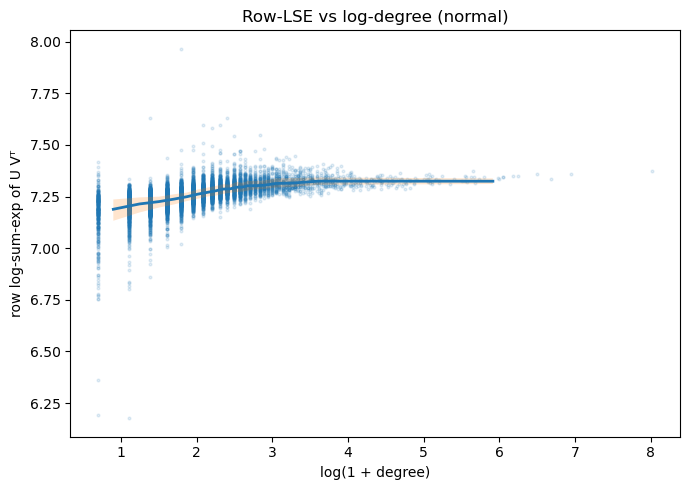

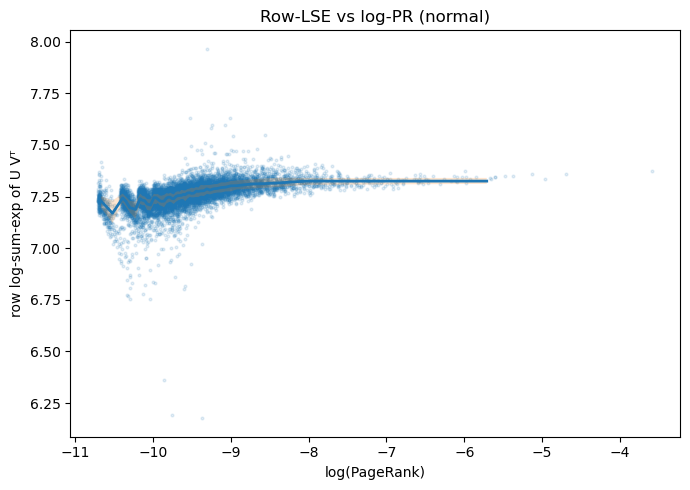

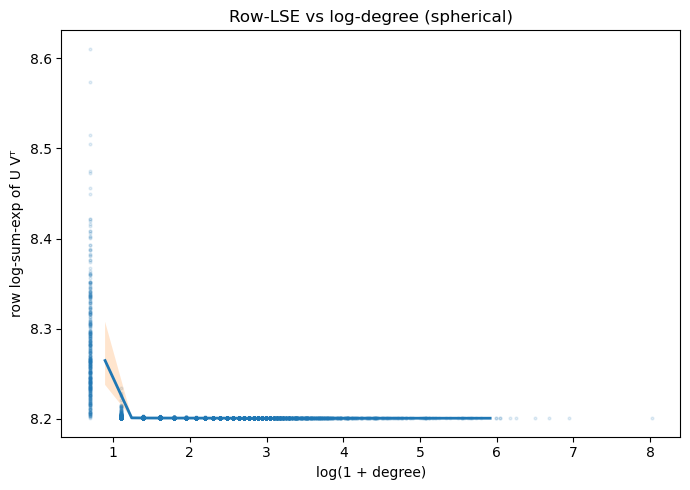

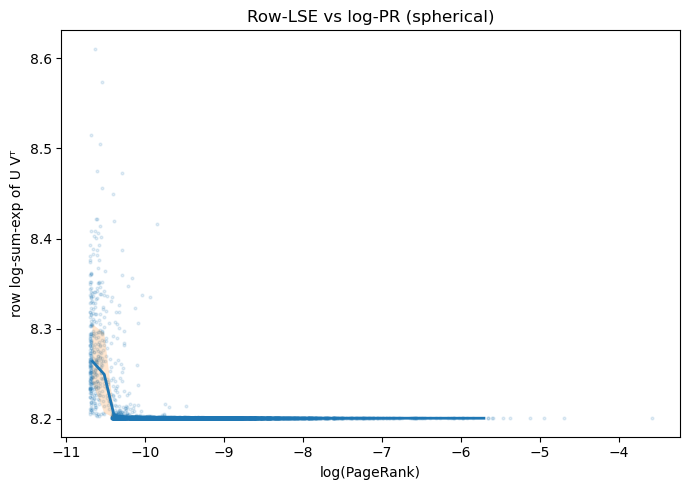

In [53]:
# Cell 3: Row-LSE plots for normal and spherical embeddings

def plot_row_lse_diagnostics(G, U, V, label="normal", pr_alpha=0.85, bins=50):
    deg = degrees_array(G)
    lg = np.log1p(deg)
    pr = pagerank_array(G, alpha=pr_alpha)
    lpr = np.log(pr + 1e-20)

    # Row LSE from UV^T
    r_lse = row_logsumexp(U, V)

    scatter_with_bands(
        lg, r_lse,
        xlabel="log(1 + degree)",
        ylabel="row log-sum-exp of U Vᵀ",
        title=f"Row-LSE vs log-degree ({label})",
        nbins=bins
    )
    scatter_with_bands(
        lpr, r_lse,
        xlabel="log(PageRank)",
        ylabel="row log-sum-exp of U Vᵀ",
        title=f"Row-LSE vs log-PR ({label})",
        nbins=bins
    )

# Example usage (uncomment to run):
plot_row_lse_diagnostics(G_het, U_het,   V_het,   label="normal")
plot_row_lse_diagnostics(G_het, U_het_s, V_het_s, label="spherical")


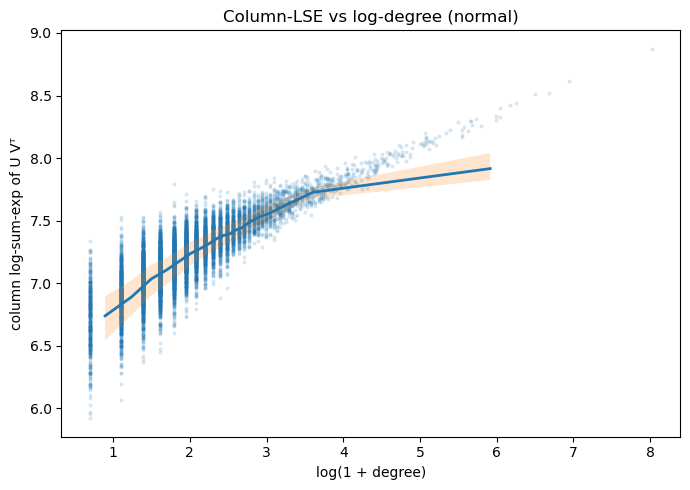

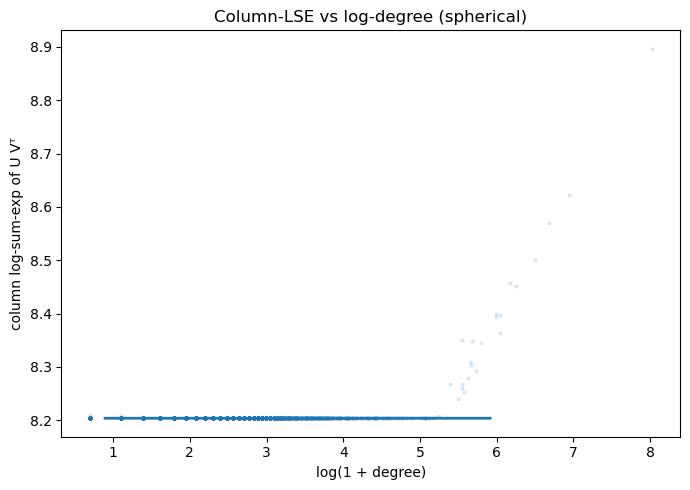

In [54]:
# Cell 4: Column-LSE vs log-degree (frequency/negative-sampling footprint)

def plot_col_lse_vs_degree(G, U, V, label="normal", bins=50):
    deg = degrees_array(G)
    lg = np.log1p(deg)
    c_lse = col_logsumexp(U, V)
    scatter_with_bands(
        lg, c_lse,
        xlabel="log(1 + degree)",
        ylabel="column log-sum-exp of U Vᵀ",
        title=f"Column-LSE vs log-degree ({label})",
        nbins=bins
    )

# Example:
plot_col_lse_vs_degree(G_het, U_het,   V_het,   label="normal")
plot_col_lse_vs_degree(G_het, U_het_s, V_het_s, label="spherical")


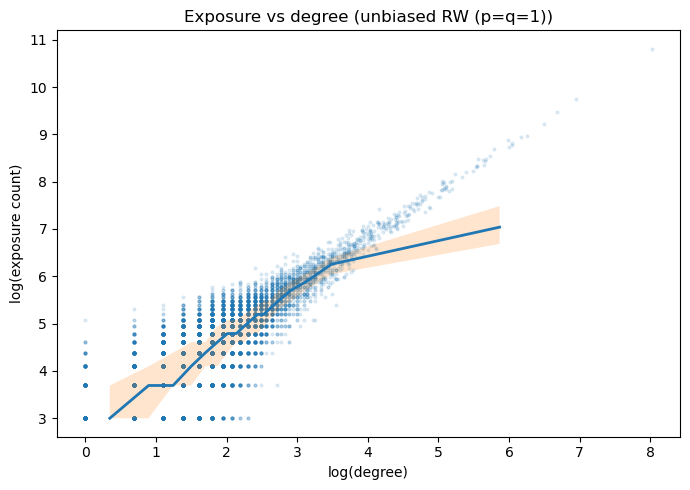

In [51]:
# Cell 5: Exposure vs degree (independent of training)

def estimate_exposure_counts(G, num_walks=40, walk_length=2000, window=10, seed=42):
    rng = np.random.default_rng(seed)
    nodes = np.fromiter(G.nodes(), dtype=int)
    idx = {u: i for i, u in enumerate(nodes)}
    C = np.zeros(len(nodes), dtype=np.int64)
    for _ in range(num_walks):
        v = rng.choice(nodes)
        for _ in range(walk_length):
            C[idx[v]] += (2 * window)  # double-sided window
            nbrs = list(G[v])
            if not nbrs:
                break
            v = rng.choice(nbrs)
    return C

def plot_exposure_vs_degree(G, window=10, label="walk/window", bins=40):
    deg = degrees_array(G)
    C = estimate_exposure_counts(G, num_walks=40, walk_length=2000, window=window, seed=42)
    mask = (deg > 0) & (C > 0)
    x = np.log(deg[mask]); y = np.log(C[mask])
    scatter_with_bands(
        x, y,
        xlabel="log(degree)",
        ylabel="log(exposure count)",
        title=f"Exposure vs degree ({label})",
        nbins=bins
    )

# Example:
plot_exposure_vs_degree(G_het, window=10, label="unbiased RW (p=q=1)")


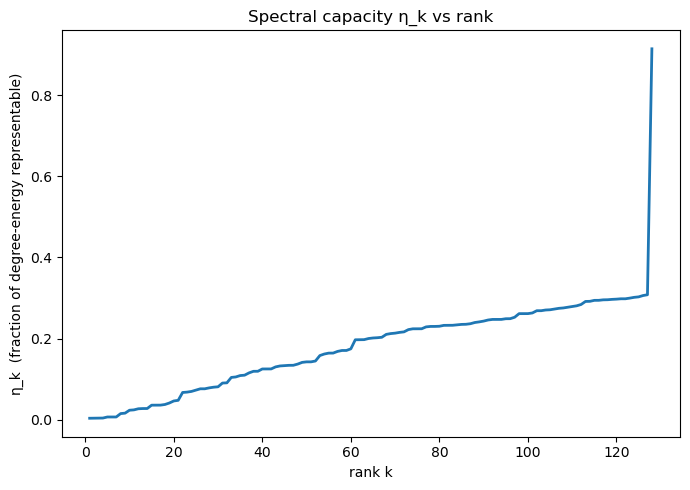

In [52]:
# Cell 6: Spectral capacity η_k vs rank k (how much degree-energy is representable)

def spectral_capacity_curve(G, kmax=128):
    A = nx.to_scipy_sparse_array(G, format="csr")
    d = np.asarray(A.sum(axis=1)).ravel()
    n = A.shape[0]
    kmax = min(kmax, n-2)

    invsqrt = 1.0 / np.sqrt(np.clip(d, 1e-12, None))
    Dm12 = sp.diags(invsqrt)
    S = Dm12 @ A @ Dm12  # symmetric normalized adjacency

    # Largest algebraic eigenpairs
    vals, vecs = eigsh(S, k=kmax, which="LA")
    vecs = np.asarray(vecs)  # (n, kmax)

    # Degree feature (centered log(1+d)) lifted by sqrt(D)
    z = np.log1p(d); z = z - z.mean()
    w = np.sqrt(np.clip(d, 1e-12, None)) * z

    # Orthonormal basis for span{ sqrt(D) * u_i }
    B = (np.sqrt(np.clip(d, 1e-12, None))[:, None]) * vecs  # (n,kmax)
    Q, _ = np.linalg.qr(B, mode="reduced")                  # (n,kmax)

    # cumulative eta_k
    denom = float(w @ w) if float(w @ w) > 0 else np.nan
    ks = np.arange(1, kmax + 1)
    etas = []
    for k in ks:
        Qk = Q[:, :k]
        proj = Qk @ (Qk.T @ w)
        num = float(proj @ proj)
        etas.append(num / denom if denom > 0 else np.nan)
    return ks, np.array(etas)

def plot_spectral_capacity(G, kmax=128, title="Spectral capacity η_k vs rank"):
    ks, etas = spectral_capacity_curve(G, kmax=kmax)
    plt.figure(figsize=(7,5))
    plt.plot(ks, etas, linewidth=2)
    plt.xlabel("rank k")
    plt.ylabel("η_k  (fraction of degree-energy representable)")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Example:
plot_spectral_capacity(G_het, kmax=128)
